![picture](picture.jpg)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
#Data
np.random.seed(10)
rho=1
startpoint=0
L=2
Aa=0.5
Ae=0.1
p0=10
pE=0
m_dot=1


n=4 # 5 contur volumes
# n=100
h=(L-startpoint)/n
x_u=np.linspace(startpoint + h / 2, L - h / 2, n) 
x_p=np.linspace(startpoint,L,n+1) 

Au= x_u * (Ae - Aa) / L + Aa
Ap=x_p*(Ae-Aa)/L +Aa

u=m_dot/(rho * Au)
p= (x_p) * (pE - p0) / L + p0

print(u)
print(p)
# x

[2.22222222 2.85714286 4.         6.66666667]
[10.   7.5  5.   2.5  0. ]


![exact_solution](exact_solution.jpg)

m_exact: 0.4472135954999579
p_exact: [ 9.60000000e+00  9.37500000e+00  8.88888889e+00  7.50000000e+00
 -3.55271368e-15]


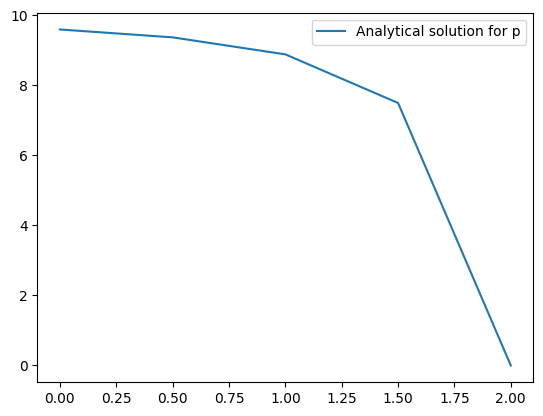

In [39]:
#Exact solution for 4 nodes case
m_exact=np.sqrt((p0-pE)*2*rho*Ae*Ae)
p_exact=p0-m_exact*m_exact/(2*rho*Ap*Ap)

print("m_exact:",m_exact)
print("p_exact:",p_exact)
plt.plot(x_p,p_exact,label="Analytical solution for p")
plt.legend()
plt.show()

![governing_equations](governing_equations.jpg)

![SIMPLE_scheme](SIMPLE_scheme.jpg)

In [40]:
def SIMPLE_solve(u1, p1,Au1, Ap1, rho1,p01, n1, alpha=0.8, stop_iter=-1, eps=10e-5,iter=0):
    u_star=np.zeros(n1)
    d_values=np.zeros(n1)
    # L node
    FwL=rho1*(u1[n1-1]+u1[n1-2])*Ap1[n1-1]/2
    FeL=rho1*u1[n1-1]*Ap1[n1-1]
    # if first iteration, we can use FeL=m_dot##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if iter==0:
        FeL=1
    aWL=max(0,FwL)
    aEL=max(0,-FeL)
    aPL=aWL+aEL+(FeL-FwL)
    SuL=(p1[-2]-p1[-1])*Au1[n1-1]
    dL=Au1[n1-1]/aPL
    d_values[-1]=dL
    # print(FwL,FeL,aPL,SuL,dL)
    
    # 0 node
    Fw0=rho1*u1[0]*Au1[0]
    Fe0= rho1 * Ap1[1] * (u1[1]+u1[0])/2
    aW0=0
    aE0=0
    
    # aP0=Fe0+Fw0*(Au1[0]*Au1[0])/(2*Ap1[0]*Ap1[0])-Fw0*Au1[0]/Ap1[0]
    # Su0=(p01-p1[1])*Au1[0]

    aP0=Fe0+Fw0*(Au1[0]/Ap1[0])*(Au1[0]/Ap1[0])/2 
    Su0=(p01-p1[1])*Au1[0]+Fw0*u1[0]*Au1[0]/Ap1[0]
    
    d=Au1[0]/aP0
    d_values[0]=d
    print("Fw0,Fe0,aP0,Su0,d:", Fw0,Fe0,aP0,Su0,d)

    u_star[0]=Su0/aP0
    
    aP_arr=np.zeros(n1)
    Su_arr=np.zeros(n1)
    aW_arr=np.zeros(n1-1)
    aE_arr=np.zeros(n1-1)

    aE_arr[-1]=aWL
    
    Su_arr[0]=Su0
    Su_arr[-1]=SuL
    aP_arr[0]=aP0
    aP_arr[-1]=aPL
    
    for i in range(1,n1-1):
        uw=(u1[i-1]+u1[i])/2
        ue=(u1[i+1]+u1[i])/2
        Fw= rho1 * Ap1[i] * uw
        Fe= rho1 * Ap1[i + 1] * ue
        aW=max(0,Fw)
        aE=max(0,-Fe)
        # aw=Fw
        # aE=0
        aP=aW+aE+(Fe-Fw)
        dp=p1[i]-p1[i+1]        
        Su=dp*Au1[i]
        d= Au1[i] / aP
        d_values[i]=d
        
        # if i==1:
        #     print(Fw,Su,aP,d)
        u_star[i]=(aW*u_star[i-1]+Su)/aP
        
        
        aP_arr[i]=aP
        Su_arr[i]=Su
        aW_arr[i]=aW
        aE_arr[i]=aE
            
    u_star[n1-1]=(aWL*u_star[n1-2]+SuL)/aPL
    
    
    M=np.zeros((n1+1,n1+1))
    B_hatch=np.zeros(n1+1)
    

    M[0,0]=1
    B_hatch[0]=0
    M[-1,-1]=1
    B_hatch[-1]=0
    
    for i in range(1,n1):
        aW=rho1*d_values[i-1]*Au1[i-1]
        aE=rho1*d_values[i]*Au1[i]
        Fw_star=rho1*u_star[i-1]*Au1[i-1]
        Fe_star=rho1*u_star[i]*Au1[i]
        aP=aW+aE
        B_hatch[i]=Fw_star-Fe_star
        M[i,i]=aP
        M[i,i-1]=-aW
        M[i,i+1]=-aE
        # if i==1:
        #     print(aW,aE,Fw_star,Fe_star,aP,b_hatch)
    # print(M,B_hatch)
        
    p_corr=np.linalg.solve(M,B_hatch)
    # print(p_corr)
    p_new=p1+p_corr
    
    u_new=u_star+d_values*(p_corr[:-1]-p_corr[1:])
    # u_new=u_star
    
    # p_new[0]=p01-rho1*u_new[0]*Au1[0]*u_new[0]*Au1[0]/(2*Ap1[0]*Ap1[0])
    p_new[0]=p01-rho1*(u_new[0]*Au1[0]/Ap1[0])*(u_new[0]*Au1[0]/(2*Ap1[0]))
    # print(p_new)

    u_final=(1-alpha)*u1+alpha*u_new
    p_final=(1-alpha)*p1+alpha*p_new
    

    # print("mass flow check:",rho1*u_new2*Au1)
    pres=abs(abs(aP_arr[1:]*u_final[1:]-aW_arr*u_final[:-1]-aE_arr*u_final[1:]-Su_arr[1:]).sum() +aP_arr[0]*u_final[0]-Su_arr[0])

    if ((iter<stop_iter) | (stop_iter==-1)) & ((pres>eps) |(eps==-1)):
        # print(aP0,Su0)
        # print({"p":p_new_final,"u":u_new_final})
        return SIMPLE_solve(u_final, p_final, Au1, Ap1, rho1,p01, n1,alpha,stop_iter,eps,iter+1)
    else:
        return {"p":p_final,"u":u_final, "pres":pres}

In [41]:
solution=SIMPLE_solve(u, p, Au, Ap, rho,p0, n,0.8,1)
p_simple=solution["p"]
u_simple=solution["u"]
print(solution)

Fw0,Fe0,aP0,Su0,d: 1.0 1.0158730158730158 1.4208730158730158 3.125 0.31670669720158634
Fw0,Fe0,aP0,Su0,d: 0.804856534195242 0.8176320347380236 1.1435989310870966 1.8304199210790943 0.3934945965472645
{'p': array([ 9.48190833,  9.99776404, 10.42024457,  9.93226692,  0.        ]), 'u': array([1.17138239, 1.50606307, 2.10848829, 3.51414716]), 'pres': 1.8569862616376533}


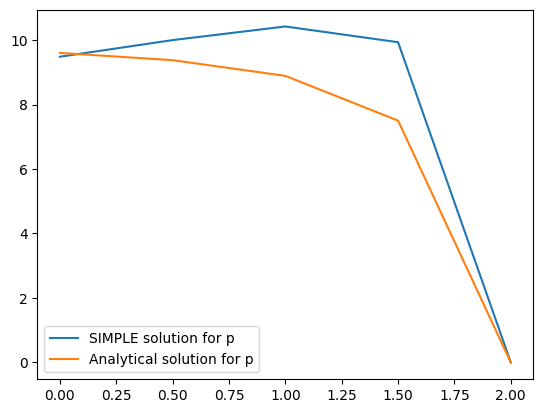

In [42]:
plt.plot(x_p,p_simple,label="SIMPLE solution for p")
plt.plot(x_p,p_exact,label="Analytical solution for p")
plt.legend()
plt.show()

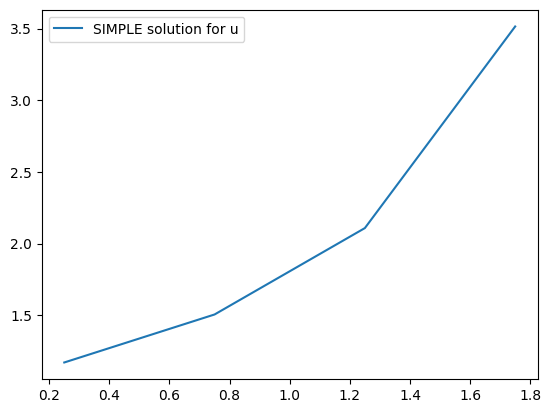

In [43]:
plt.plot(x_u,u_simple,label="SIMPLE solution for u")
plt.legend()
plt.show()